# Introduction to Reinforcement Learning
## Open AI Gym with A2C and PyGame

### First, some primary references:

This notebook makes use of the Open AI Gym Environment
* https://gym.openai.com/docs/
* https://openai.com/blog/baselines-acktr-a2c/

A2C is an Actor Critic Model

*A2C is a synchronous, deterministic variant of Asynchronous Advantage Actor Critic (A3C) which we’ve found gives equal performance [to ACKTR]*

Open AI has a Gym that registers the reinforcement learning environment (the game)
* Some of the Open AI Framework depends on loading the environment from the Open AI Gym registry
* A custom pip module has been created so that the gym can register the pygame environment module.  If the model couldn't be loaded from the registry, some of the Open AI classes didn't work as expected.
* https://towardsdatascience.com/beginners-guide-to-custom-environments-in-openai-s-gym-989371673952

The notebook borrows heavily from the Open AI stable baselines3 tutorial:
* https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb

The notebook also includes code based on PyGame tutorials:
* https://opensource.com/article/17/12/game-python-add-a-player (parts 3-5)
* Similar to above, assume that the code has been taken from the tutorials.  Images are different and rewards are changed, but the tutorial was the baseline and modifications were made on top.

### Description


This notebook uses a simple PyGame with the Open AI Learning model A2C, which is one of the few that handles Discrete input


![PyGame Start](https://drive.google.com/uc?export=view&id=1ySLQIin9tbsNyYujjL-kKpk3n3NFgvXe)




How the game works:
* 1 player/agent (penguin)
* 1 "enemy" (person)
* movement goes along an X axis
* The player is rewarded for each movement (left or right)
* If the player collides with the enemy, it gets a penalty
* If the player is near the enemy (without colliding) it gets higher rewards
* If the player is just moving, it gets a reward

Open AI A2C will input the PyGame image output (a numpy array)

Note that while the game versions may differ slightly across the project notebooks, they are conceptually the same.  The TensorFlow environment version is different in the observations it outputs, which align to Tensors of the TensorFlow API


![PyGame Start](https://drive.google.com/uc?export=view&id=1OWKQ5qEm5I6ltkOZpLi4sKSgrMSQjwiY)

## PIP installs

Below this is conditional to reduce unnecessary imports.  To run
set 
```
run_pip=True
```

In [ ]:
run_pip = True
if run_pip:
  !pip install tf-agents
  !pip install opencv-python 
  !pip install pillow
  !pip install pygame
  !pip install --upgrade tensorflow-probability
  !pip install ray
  !pip install tensorboard
  !pip install tensorflow-gpu #(which gives you tensorflow-gpu and tensorboard)
  !pip install stable_baselines3
  !pip install lz4

     |████████████████████████████████| 1.2MB 14.6MB/s 
     |████████████████████████████████| 4.8MB 53.4MB/s 
  Found existing installation: tensorflow-probability 0.12.1
    Uninstalling tensorflow-probability-0.12.1:
      Successfully uninstalled tensorflow-probability-0.12.1
     |████████████████████████████████| 11.8MB 15.3MB/s 
     |████████████████████████████████| 5.4MB 14.5MB/s 
ERROR: tf-agents 0.8.0 has requirement tensorflow-probability==0.12.2, but you'll have tensorflow-probability 0.13.0 which is incompatible.
  Found existing installation: tensorflow-probability 0.12.2
    Uninstalling tensorflow-probability-0.12.2:
      Successfully uninstalled tensorflow-probability-0.12.2
     |████████████████████████████████| 49.4MB 88kB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 1.0MB 57.4MB/s 
     |████████████████████████████████| 1.3MB 45.8MB/s 
     |████████████

     |████████████████████████████████| 454.3MB 37kB/s 
     |████████████████████████████████| 153kB 14.5MB/s 
     |████████████████████████████████| 1.8MB 13.5MB/s 


## Imports


In [ ]:
import imageio
import numpy as np 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython import display
from IPython.core.display import HTML 
import IPython
import base64
from io import StringIO
import pygame
import cv2
import time
import PIL.Image
import random
from IPython.display import Image
from IPython.core.display import HTML 
import gym
from gym import Env, spaces


import os
from google.colab import output


font = cv2.FONT_HERSHEY_COMPLEX_SMALL 


pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
from tensorflow import TensorShape, TensorSpec

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import BoundedArraySpec

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common



from gym import Env
from gym.spaces import Discrete, Box


tf.compat.v1.enable_v2_behavior()

## Google Drive For Files
### This is used for images and saving models


In [ ]:

working_dir = 'MyDrive'
drive_dir = '/content/drive'

image_dir = 'my-custom-gym/my_custom_gym/envs/pygame_images' 
model_dir = 'models'
output_dir = 'output'

In [ ]:
from google.colab import drive
drive.mount(drive_dir)  # Do this once only

mounted_drive = f'{drive_dir}/{working_dir}'
os.chdir(mounted_drive)
full_output_dir = f'{mounted_drive}/{output_dir}'
if not os.path.exists(full_output_dir):
    os.makedirs(full_output_dir)

Mounted at /content/drive


### Known Issue: PyGame file system dependencies

The game has dependencies on the installation of image files and PIP module files
* The notebook working directory needs to be set in the image file directory when running the game.  Otherwise the game can't find its images.
* PIP module needs to be copied to Google Drive for the Colab notebook to find it and do the PIP install


The pip tar file can be found in the git repo directory "installed_tars".  The image files are contained in that tar file, so there is only one tar that is needed.  Copy them up to the google drive and untar them.  **Make sure the working directory is set properly so that the image files can be accessed**

## PIP Install Custom PyGame Gym Env

The code for the Open AI Gym Env is located in the git repository under notebooks/pip-module

Per the [Open AI Repository](https://github.com/openai/gym) 


The core gym interface is Env, which is the unified environment interface. There is no interface for agents; that part is left to you. The following are the Env methods you should know:

* reset(self): Reset the environment's state. Returns observation.
* step(self, action): Step the environment by one timestep. Returns observation, reward, done, info.
* render(self, mode='human'): Render one frame of the environment. The default mode will do something human friendly, such as pop up a window.

(For this project, the default mode just returns the numpy array for the "human" mode)


* Untar the pip module on google drive
* Run command to install the module

In [ ]:

os.chdir(f'{mounted_drive}')
!tar -xvf my-custom-gym.tar
os.chdir(f'{mounted_drive}/my-custom-gym')
!pip install -e .
import gym
import my_custom_gym
os.chdir(f'{mounted_drive}')

my-custom-gym/README.md
my-custom-gym/__init__.py
my-custom-gym/my_custom_gym/
my-custom-gym/my_custom_gym/__init__.py
my-custom-gym/my_custom_gym/__pycache__/
my-custom-gym/my_custom_gym/envs/
my-custom-gym/my_custom_gym/envs/__init__.py
my-custom-gym/my_custom_gym/envs/pygame_images/
my-custom-gym/my_custom_gym/envs/__pycache__/
my-custom-gym/my_custom_gym/envs/my_py_game_env.py
my-custom-gym/my_custom_gym/envs/__pycache__/__init__.cpython-38.pyc
my-custom-gym/my_custom_gym/envs/__pycache__/foo_env.cpython-38.pyc
my-custom-gym/my_custom_gym/envs/__pycache__/my_py_game_env.cpython-38.pyc
my-custom-gym/my_custom_gym/envs/pygame_images/._enemy.png
my-custom-gym/my_custom_gym/envs/pygame_images/enemy.png
my-custom-gym/my_custom_gym/envs/pygame_images/hero4.png
my-custom-gym/my_custom_gym/envs/pygame_images/._stage.jpg
my-custom-gym/my_custom_gym/envs/pygame_images/stage.jpg
my-custom-gym/my_custom_gym/envs/pygame_images/hero3.png
my-custom-gym/my_custom_gym/envs/pygame_images/hero2.png
m

## Import new Gym Env and set back working dir

In [ ]:

import gym

from stable_baselines3 import A2C
from stable_baselines3.a2c import MlpPolicy
from stable_baselines3.common.cmd_util import make_vec_env

# https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb#scrollTo=R7tKaBFrTR0a

from stable_baselines3.common.monitor import Monitor



/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/cmd_util.py:6: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  "Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.", FutureWarning


In [ ]:
# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Notebook Seed

In [ ]:
notebook_seed = 2021
tf.random.set_seed(notebook_seed)
random_num_generator = np.random.default_rng(notebook_seed)
os.environ['PYTHONHASHSEED']=str(notebook_seed)

In [ ]:
os.chdir(f'{mounted_drive}')
kwargs={'random_num_generator': random_num_generator, 'image_dir': image_dir}
env = gym.make('custom-py-game-env-v0', **kwargs) # name of custom pygame environment module


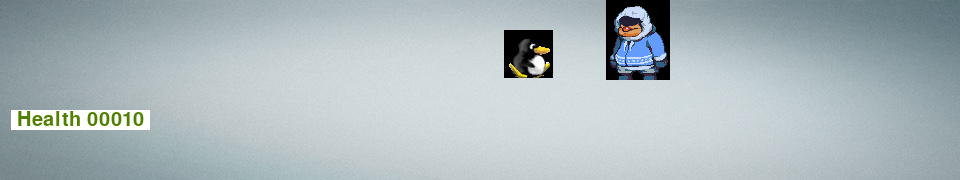

In [ ]:
reset_output = env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

## PyGame States, Actions, and Rewards

Reinforcement Learning uses **states**, **actions** and **rewards** to train the model
* States are snapshots of the pertinent data at the time
* Since we are conserving on memory, only 3 parameters are being passed to the model from the observation  
* Actions are passed into the Environment through the step method
* Rewards are passed back through the observation as reward
* TensorFlow timesteps are made up of **(state, reward, step type, and discount)**
#### Step/Action values

**Active Values**
* 0 = Left
* 1 = Right


![RL breakdown](https://drive.google.com/uc?export=view&id=1-OiCYCB7ySyj-GgrfND4WghpsLdBacqk)

Because Deep Q Networks use a lot of memory, a simple CNN has been used to read the game rendered images.  The training also has less steps than what was done for the 130-pygame-discrete-dqn notebook.  All the notebooks take discrete input; however the CNN is using numpy float image arrays.

Note that while the game versions may differ slightly across the project notebooks, they are conceptually the same.  The TensorFlow environment version is different in the observations it outputs, which align to Tensors of the TensorFlow API

%%html
<style>
table {float:left}
</style>


| State feature | Reward  |
|---|----|
| Player moves left or right within image bounds | +10 points |
| Player moves in a region close to the "Enemy" | + 25 points |
| Player collides with "Enemy" | -100 |

### Check Game Setup
Check to see that the environment/game can run 100 steps/actions.  Show the end state with the rendered image.

Environment observation space: Box(0, 255, (180, 960, 3), uint8)
env.action_space
1
average -1.15


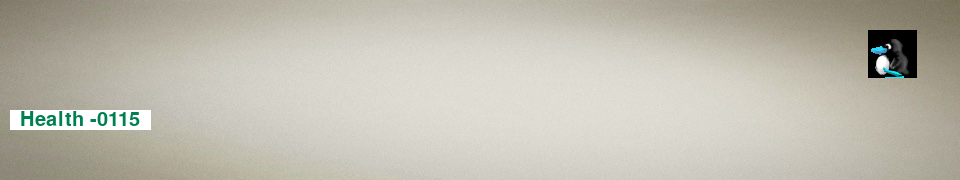

In [ ]:
print(f'Environment observation space: {env.observation_space}')
print(f'env.action_space')
print(env.action_space.sample())

n_steps = 100
total_rewards = 0
counter = 0
for step in range(0,100):
    obs, reward, done, info = env.step(env.action_space.sample())  
    total_rewards += reward
    counter += 1
    
avg_reward = total_rewards/counter
print(f'average {avg_reward}')
      #break
cv2_imshow(obs)

Instantiate model.  Note that each Open AI model has its own specific MlpPolicy class

In [ ]:


model = A2C(MlpPolicy, env, verbose=1)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


Add a monitor to the environment to capture any logging

In [ ]:
# https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/master/monitor_training.ipynb#scrollTo=kmxIq5UeC3Nj
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

## Get Model Baseline

Function creates a gif from a number of steps/actions in the environment

In [ ]:
def embed_gif(filename):
  """Embeds an gif file in the notebook."""
  img = open(filename,'rb').read()
  b64 = base64.b64encode(img)
  tag = '''
    <img src="data:image/gif;base64,{0}"/>
'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_gif(model, gif_name):
  images = []
  obs = model.env.reset()
  img = model.env.render(mode='rgb_array')
  for i in range(350):
      images.append(img)
      action, _ = model.predict(obs)
      obs, _, _ ,_ = model.env.step(action)
      img = model.env.render(mode='rgb_array')

  imageio.mimsave(f'{gif_name}.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
  images = []


In [ ]:
chart_name = 'before_a2c_pygame'
create_gif(model, chart_name)
full_chart_name = f'{chart_name}.gif'
embed_gif(full_chart_name)

Function to plot initial evaluation


In [ ]:
def plot_evaluation(values, x_label, y_label, chart_name):
  iterations = range(0, len(values))
  plt.figure(figsize=(10,4))
  
  plt.plot(iterations, values, alpha=.2)
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.savefig(f'{full_output_dir}/{chart_name}')

The method below comes straight from the Stable Baselines3 tutorial.  We will evaluate the model with a number of episodes **before we train it to get our baseline**

In [ ]:
# Test the trained agent
def evaluate(model, num_episodes=100, chart_name=None):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    episodes = []
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))
    if chart_name != None:
      print(all_episode_rewards)
      plot_evaluation(all_episode_rewards, 'Iterations', 'Average Cummulative Score', chart_name)
    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

time 299619
time 560932
[array([10025.], dtype=float32), array([8660.], dtype=float32), array([9340.], dtype=float32), array([-3395.], dtype=float32), array([6055.], dtype=float32), array([5480.], dtype=float32), array([-2915.], dtype=float32), array([9630.], dtype=float32), array([10295.], dtype=float32), array([-4605.], dtype=float32), array([5320.], dtype=float32), array([1320.], dtype=float32), array([10015.], dtype=float32), array([9870.], dtype=float32), array([-4325.], dtype=float32), array([-4710.], dtype=float32), array([6915.], dtype=float32), array([6685.], dtype=float32), array([5045.], dtype=float32), array([9950.], dtype=float32), array([4490.], dtype=float32), array([-3125.], dtype=float32), array([300.], dtype=float32), array([-3380.], dtype=float32), array([8595.], dtype=float32), array([-1870.], dtype=float32), array([9550.], dtype=float32), array([-4590.], dtype=float32), array([9845.], dtype=float32), array([9840.], dtype=float32), array([9690.], dtype=float32), arr

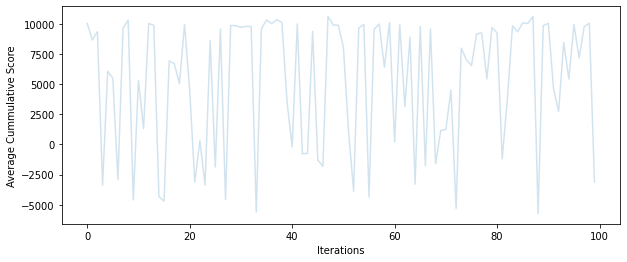

In [ ]:
mean_reward_before_train = evaluate(model, num_episodes=100, chart_name='before_train_a2c_eval.png')

Now run the evaluate policy for further diagnostics.  Due to memory limitations, only 30 episodes are run

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=30)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-15620.33 +/- 2922.12


## Train A2C model and save it

Here we use only 20000 steps.  This takes hours.  A number of stats are output.  

For Reinforcement Learning, our main metric will be checking the average scores on the games.  For this particular exercise, we will not be charting the stats below.

In [ ]:
model.learn(total_timesteps=20000)
model.save("a2c_pygame_model")

------------------------------------
| time/                 |          |
|    fps                | 100      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.689   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 21.6     |
|    value_loss         | 1.04e+03 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 516       |
|    ep_rew_mean        | -3.77e+03 |
| time/                 |           |
|    fps                | 101       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.692    |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 

## Evaluate Trained Model

Get the average reward per 100 episodes.  Although the method says before training, this will apply as the mean for a trained model.  At this point, the model has already gone through training.


In [ ]:
mean_reward_after_train = evaluate(model, num_episodes=100, chart_name='after_train_a2c_eval.png')

In [24]:
print(f'mean reward before train {mean_reward_before_train}')
print(f'mean reward after train {mean_reward_after_train}')

mean reward before train 5254.14990234375
mean reward after train 1424.1500244140625


Below create a gif to see 350 steps and save it to a file.

In [25]:
def create_gif(model, gif_name):
  images = []
  obs = model.env.reset()
  img = model.env.render(mode='rgb_array')
  for i in range(350):
      images.append(img)
      action, _ = model.predict(obs)
      obs, _, _ ,_ = model.env.step(action)
      img = model.env.render(mode='rgb_array')

  imageio.mimsave(f'{gif_name}.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
  images = []


In [26]:
chart_name = 'after_a2c_pygame'
create_gif(model, chart_name)
full_chart_name = f'{chart_name}.gif'
embed_gif(full_chart_name)

In [27]:
print(f'mean reward before train {mean_reward_before_train}')
print(f'mean reward after train {mean_reward_after_train}')